# Maaslin 2 Analysis 
###  COVIRT19 microbial subgroup seqscreen analysis 
#### Date : 21 DEC 2020 
#### Maintained by :
    Jochum, Michael D. 
    Baylor College of Medicine 
    michael.jochum@bcm.edu

#### The purpose of this code is to:
- identify GO terms assocaited with COVID19 via maaslin2

- load the libraries
- set the environment
- import the data from the dmm clustering analysis

In [92]:
library(tidyverse)
library(phyloseq)
library(Maaslin2)

In [93]:
setwd('../')

[1] "/media/jochum00/Aagaard_Raid3/jupyter_notebooks/jochum00_jupyter/microbial/GO_term_analysis/16_DEC_2020_dmm_troubleshooting_Lee"

In [94]:
#load(file = "1_dmm.RDA")
load(file = "0_preprocessing.RDA")

Transform GO Terms counts to relative abundances

In [95]:
term_pseq_no_neg_comp<-microbiome::transform(x = term_pseq_no_neg,transform = "compositional")

In [99]:
library(microbiome)
unique(meta(term_pseq_no_neg_comp)$case)


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform




[1] "COVID19"                      "Community_acquired_pneumonia"
[3] "Control_Healthy"              "Control_Neg"

# MaAsLIN2

In [96]:
df_input_data<-data.frame(t(otu_table(term_pseq_no_neg_comp)))
df_input_metadata<-data.frame(sample_data(term_pseq_no_neg_comp))

[1] "Warning: Deleting existing log file: ./terms_vs_case_comp_norm/maaslin2.log"
2020-12-22 05:23:23 INFO::Writing function arguments to log file
2020-12-22 05:23:23 INFO::Verifying options selected are valid
2020-12-22 05:23:23 INFO::Determining format of input files
2020-12-22 05:23:23 INFO::Input format is data samples as rows and metadata samples as rows
2020-12-22 05:23:24 INFO::Formula for random effects: expr ~ (1 | sample_name) + (1 | publication)
2020-12-22 05:23:24 INFO::Formula for fixed effects: expr ~  case
2020-12-22 05:23:24 INFO::Filter data based on min abundance and min prevalence
2020-12-22 05:23:24 INFO::Total samples in data: 91
2020-12-22 05:23:24 INFO::Min samples required with min abundance for a feature not to be filtered: 9.100000
2020-12-22 05:23:24 INFO::Total filtered features: 13745
2020-12-22 05:23:24 INFO::Filtered feature names from abundance and prevalence filtering: GO.0000002.mitochondrial.genome.maintenance, GO.0000003.reproduction, GO.0000006.high

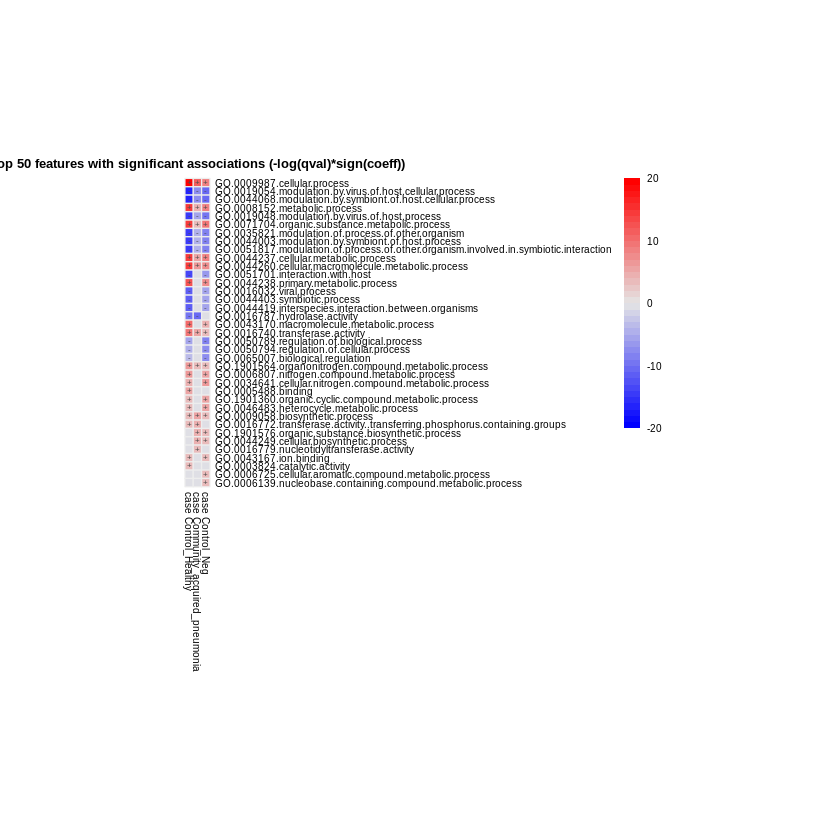

In [97]:
case_norm<-Maaslin2(
  input_data = df_input_data,
  input_metadata = df_input_metadata,
  output="./results/terms_vs_case_comp_norm",
  min_abundance = 0.01, #UPDATE for more terms: lowered miminum rel. abundance 0.3%
  min_prevalence = 0.1, 
  normalization = "CLR",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.05,
  #random_effects = c("sample_name","publication","collection_location","sequence_type"),
  random_effects = c("sample_name","publication"),
  fixed_effects = c("case"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  heatmap_first_n =num,
  reference=c("case,COVID19"))

## MaAsLin2 outcome analyisis (pruned_samples)

In [85]:
term_pseq_outcome<-subset_samples(physeq = term_pseq_no_neg,outcome!="NA")
term_pseq_outcome_comp<-microbiome::transform(x = term_pseq_outcome,transform = "compositional")
COVID19_df_input_data<-data.frame(t(otu_table(term_pseq_outcome_comp)))
COVID19_df_input_metadata<-data.frame(sample_data(term_pseq_outcome_comp))

In [86]:
term_pseq_outcome_comp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 13534 taxa and 25 samples ]
sample_data() Sample Data:       [ 25 samples by 71 sample variables ]
tax_table()   Taxonomy Table:    [ 13534 taxa by 3 taxonomic ranks ]

#### run another model using only the COVID19 samples and identify GO Terms associated with deceased

[1] "Warning: Deleting existing log file: ./subset_outcome/maaslin2.log"
2020-12-22 03:06:28 INFO::Writing function arguments to log file
2020-12-22 03:06:28 INFO::Verifying options selected are valid
2020-12-22 03:06:28 INFO::Determining format of input files
2020-12-22 03:06:28 INFO::Input format is data samples as rows and metadata samples as rows
2020-12-22 03:06:28 INFO::Formula for random effects: expr ~ (1 | sample_name) + (1 | publication)
2020-12-22 03:06:28 INFO::Formula for fixed effects: expr ~  outcome
2020-12-22 03:06:28 INFO::Filter data based on min abundance and min prevalence
2020-12-22 03:06:28 INFO::Total samples in data: 25
2020-12-22 03:06:28 INFO::Min samples required with min abundance for a feature not to be filtered: 0.025000
2020-12-22 03:06:28 INFO::Total filtered features: 12485
2020-12-22 03:06:28 INFO::Filtered feature names from abundance and prevalence filtering: GO.0000002.mitochondrial.genome.maintenance.mitochondrial.genome.maintenance, GO.0000003.re

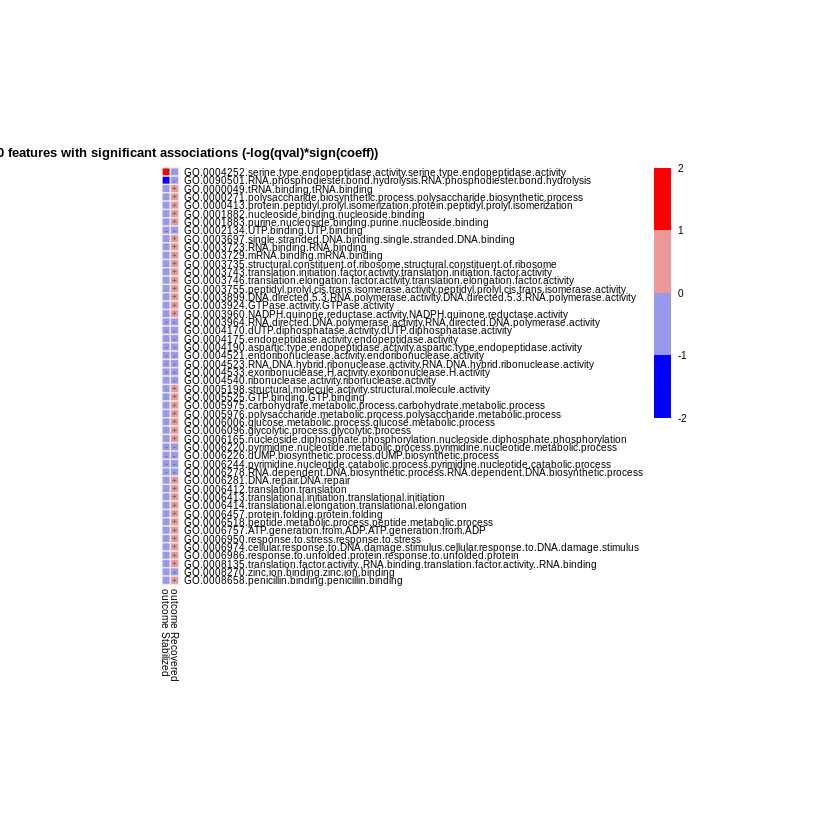

In [87]:
subset_outcome<-Maaslin2(
  input_data = COVID19_df_input_data,
  input_metadata = COVID19_df_input_metadata,
  output="./results/subset_outcome",
  min_abundance = 0.0001,
  min_prevalence = 0.001,
  normalization = "CLR",
  transform = "NONE",
  analysis_method = "LM",
  max_significance = 0.4,
  random_effects = c("sample_name","publication"),
  fixed_effects = c("outcome"),
  correction="BH",
  standardize = TRUE,
  cores = 48,
  plot_heatmap = TRUE,
  plot_scatter = TRUE,
  reference="outcome,Deceased")

In [88]:
res<-case_norm$results%>%filter(pval<=0.05)
subset_outcome_res<-subset_outcome$results%>%filter(pval<=0.01)

In [89]:
Terms<-gsub("GO.","GO:",res$feature)
Terms<-gsub("[.]"," ",Terms)
Terms<-sub(" ","-",Terms)
Terms<-as_tibble(Terms)
Terms<-separate(data = Terms,col = value,sep = "-",into =  c("Term", "name"))

In [90]:
term_pseq_prune <- prune_taxa(taxa = Terms$Term,x =term_pseq_no_neg_gonames)
term_pseq_prune #[85 taxa and 141 samples ]
tax<-data.frame(tax_table(term_pseq_prune))
names<-paste(rownames(tax),tax$name,sep="-")
taxa_names(term_pseq_prune)<-names

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 35 taxa and 86 samples ]
sample_data() Sample Data:       [ 86 samples by 72 sample variables ]
tax_table()   Taxonomy Table:    [ 35 taxa by 3 taxonomic ranks ]

In [91]:
save.image("./images/2_maaslin2.rda")